### 1 - Simplest CNN architecture

In this simple architecture, we create a simple convolutional neural network with a convolutional layer and a pool layer. 
For the convolutional layer we want to tune the hyper parameters of out_channels and kernel_size.
To fine-tune hyperparameters we will use Ray, an open source unified framowork developed by PyTorch Fundation.
Ray Tune offers a variety of search space distributions to suit different parameter tupes: loguniform, uniform, choice, randint, grid and more.

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 3 , out_channels = 8, conv_kernel_size = 3 , pool_kernel_size = 2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = out_channels, kernel_size = conv_kernel_size, padding = conv_kernel_size // 2 ) # for stride = 1, conv_kernel_size // 2 seems to be the rule of thumb
        self.pool = nn.MaxPool2d(kernel_size = pool_kernel_size)
        self.fc_layer = nn.LazyLinear(num_classes) #PyTorch infers in_feature the first time it sees data, so it always matches the flatten output

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    




Now via the config dictionary, we will define our search space 

In [3]:
from ray import tune 
import torch.optim as optim

config = {
        # Model Architecture
        "out_channels" : tune.choice([8,16,32]), 
        "conv_kernel_size" : tune.choice([3,4,7]), 
        "pool_kernel_size" : tune.choice([2, 4]), 
        
        # Training Hyperparameteres:
        "lr" : tune.loguniform(1e-4, 1e-1), 
        "batch_size" : tune.choice([16, 32, 64])

}

Datasets:

In [27]:
from torchvision import transforms, datasets


img_size = (128, 128)
train_transform = transforms.Compose([        # here we are creating a single pipeline object, later on when we will call transform on an image it will apply each transformation in order
    transforms.Resize(img_size), 
    transforms.RandomHorizontalFlip(p = 0.5), # p is the percentage, so we flip 50% of the time
    transforms.RandomRotation(degrees= 15),   # rotate each image by a small angle [-15°, 15°]
    transforms.ColorJitter(                   # random color variation
        brightness = 0.2,                     # scales images brightness by a factor in [0.8, 1.2]
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1                             # tonalità
    ),
    transforms.ToTensor(),              # converts the image into a PyTorch tensor and scales pixel values from [0,255] to [0,1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])    # for each RGB channel applies (x - 0.5)/0.5 - this turns [0,1] into [-1,1] which is conveniente for training
])


val_transform = transforms.Compose([        
    transforms.Resize(img_size), 
    transforms.ToTensor(),              
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])




train_ds = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
val_ds   = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val",   transform=val_transform)
test_ds  = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test",  transform=val_transform)


Training function.
Ray Tune requires a training function that accepts a configuration dictionary and runs the main training loop.
As Ray Tune runs diffrent trials, it updates the configuration dictionary for each trial.

SDG = Stochastic Gradient Descent: an optimization algorithm that updates your model's parameters by moving them a small step in the direction that reduces the loss, using a noisy estimate of the gradient computed from a mini-batch (rather than the full dataset)

In [ ]:
import torch.optim as optim

def train1(config, data_dir = None):
    """ Create a model instance """
    # Load datasets locally in the training function
    from torchvision import transforms, datasets
    
    img_size = (128, 128)
    train_transform = transforms.Compose([        
        transforms.Resize(img_size), 
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomRotation(degrees= 15),   
        transforms.ColorJitter(                   
            brightness = 0.2,                     
            saturation = 0.2,
            contrast = 0.2,
            hue = 0.1                             
        ),
        transforms.ToTensor(),              
        transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])    
    ])

    val_transform = transforms.Compose([        
        transforms.Resize(img_size), 
        transforms.ToTensor(),              
        transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
    ])

    train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
    val_ds_local   = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val",   transform=val_transform)
    
    cnn = SimpleCNN(
        out_channels= config["out_channels"],
        conv_kernel_size = config["conv_kernel_size"] , 
        pool_kernel_size = config["pool_kernel_size"] )
    

    device = torch.device(
        "mps" if torch.backends.mps.is_available() else "cpu" ) 
    cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


    criterion = nn.CrossEntropyLoss() # expects model outputs shaped like [batch, num_classes] (logits) and labels shaped like [batch] with integer class indices
    optimizer = optim.SGD(cnn.parameters(), lr = config["lr"], momentum = 0.9) # apply SDG updates to every trainable tensor returned by cnn.parameters()
    # momentum is an add-on to sdg that keeps a "velocity" (a running direction) based on past gradients, so updates don't react only to the current mini-batch. 
    # It addresses the issue of oscillations and slow convergence.


    trainloader = torch.utils.data.DataLoader(
        train_ds_local, 
        batch_size = int(config["batch_size"]), 
        shuffle = True, 
        num_workers = 2 
    )
    valloader = torch.utils.data.DataLoader(
        val_ds_local, 
        batch_size = int(config["batch_size"]), 
        shuffle = False, 
        num_workers = 2
    )


    for epoch in range(10):
        cnn.train() # switch the PyTorch model in training mode: this allows training-time behaviour ()
        running_loss = 0.0 # to accumulate the loss values over multiple mini-batches to print and monitor an average loss  
        n_train = 0 # counter of the number of training samples processed in the epoch

        

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device) # move batch tensors to match model device

            optimizer.zero_grad() # clears gradients from previous iteraion; PyTorch accumulates gradients by default
            outputs = cnn(inputs) # Forward pass - calling a torch.nn.Module calls its forward; computes model outputs (logits)
            loss = criterion(outputs, labels) # Computes scalar loss comparing outputs to true labels
            loss.backward() # computes gradients of loss with respect to model parameters
            optimizer.step() # updates weights using computed gradients

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size # converts 0-dim tensor to Python float and accumulates
            n_train += batch_size

        train_loss = running_loss /max(n_train, 1)

        cnn.eval()
        val_loss = 0.0
        total = 0
        correct = 0 # validation accumulators. They track average validation loss and accuracy numerator/denominator
             
    
        with torch.no_grad(): # context manager to disable gradient tracking. Speeds up validation and reduces memory by not building the computation graph
        # Note: a computation graph is a data stucture that represents how a result was computed from inputs: nodes are operations and edges carry tensors between them
            for inputs, labels in valloader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnn(inputs) # forward pass on validation data
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0) #takes loss which is usually a 0-dim / single value PyTorch tensor and extracts its numeric values as a standard python number
                
                preds = outputs.argmax(dim = 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss /max(total, 1)
        val_acc = correct / max(total, 1)

        tune.report({"loss": val_loss, "accuracy": val_acc, "train_loss": train_loss})

In [41]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import torch.optim as optim

# Shutdown existing Ray instance if any
if ray.is_initialized():
    ray.shutdown()

# Start Ray with reduced resource allocation
ray.init(ignore_reinit_error=True, include_dashboard=False, num_cpus=4)

scheduler = ASHAScheduler(
    max_t=10,          # matches max_epochs in train1
    grace_period=1,
    reduction_factor=2
)

cpus_per_trial = 2

tuner = tune.Tuner(
    tune.with_resources(train1, resources={"cpu": cpus_per_trial}),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=10,   # number of trials
    ),
    param_space=config,    # your search space dict from the notebook
)

result_grid = tuner.fit()


(raylet) /Users/alessandro/Progetti/RockPaperScissorNew/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
(train1 pid=11349) /Users/alessandro/Progetti/RockPaperScissorNew/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020 [repeated 15x across cluster]
(train1 pid=11349)   warnings.warn( [repeated 15x across cluster]
(pid=gcs_server) [2026-01-29 22:59:53,037 E 11337 1056701] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc

Best config:
 {'out_channels': 16, 'conv_kernel_size': 4, 'pool_kernel_size': 2, 'lr': 0.0016672728189272912, 'batch_size': 16}
Best final metrics:
 {'loss': 0.2543530586215616, 'accuracy': 0.9355828220858896, 'train_loss': 0.27991910186334035, 'timestamp': 1769724321, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 10, 'trial_id': 'c7bee_00003', 'date': '2026-01-29_23-05-21', 'time_this_iter_s': 26.302922010421753, 'time_total_s': 262.19283175468445, 'pid': 11418, 'hostname': 'Alessandros-MacBook-Air.local', 'node_ip': '127.0.0.1', 'config': {'out_channels': 16, 'conv_kernel_size': 4, 'pool_kernel_size': 2, 'lr': 0.0016672728189272912, 'batch_size': 16}, 'time_since_restore': 262.19283175468445, 'iterations_since_restore': 10, 'experiment_tag': '3_batch_size=16,conv_kernel_size=4,lr=0.0017,out_channels=16,pool_kernel_size=2'}


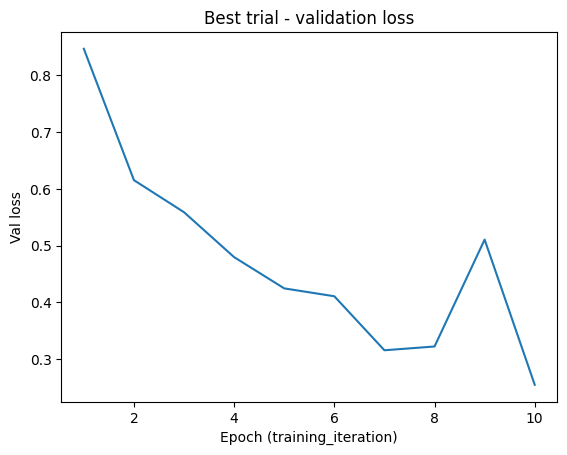

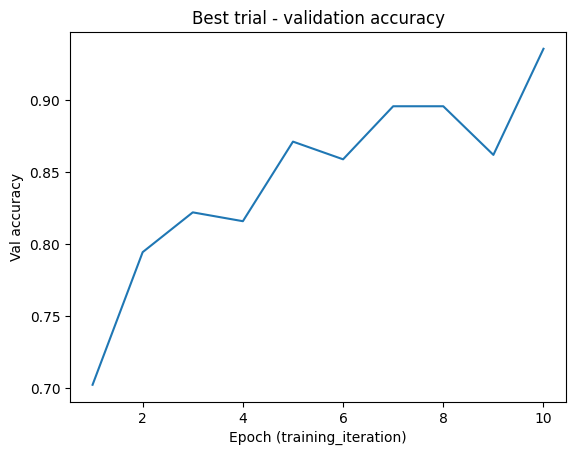

,out_channels,conv_kernel_size,pool_kernel_size,lr,batch_size,final_loss,final_accuracy
3,16,4,2,0.001667,16,2.543531e-01,0.935583
4,8,7,4,0.006288,32,2.611903e-01,0.926380
9,8,7,2,0.005923,16,4.165725e-01,0.877301
0,8,3,2,0.002088,64,5.885705e-01,0.773006
2,8,4,4,0.001391,32,7.941008e-01,0.745399
6,8,3,2,0.001514,64,8.832714e-01,0.702454
7,8,4,2,0.022316,16,1.100248e+00,0.346626
5,8,3,2,0.067743,64,1.102288e+00,0.343558
8,8,4,2,0.098177,64,1.724989e+02,0.214724
1,32,7,2,0.039473,32,6.761411e+12,0.322086


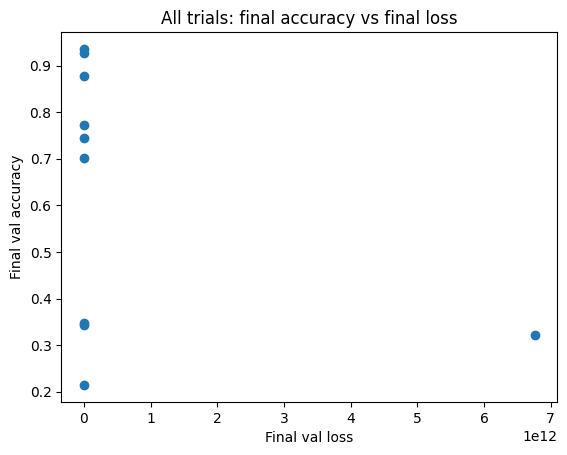

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

best_result = result_grid.get_best_result(metric="loss", mode="min")
print("Best config:\n", best_result.config)
print("Best final metrics:\n", best_result.metrics)

# Per-epoch history for best trial
df_best = best_result.metrics_dataframe  # columns include: training_iteration, loss, accuracy, train_loss

plt.figure()
plt.plot(df_best["training_iteration"], df_best["loss"])
plt.xlabel("Epoch (training_iteration)")
plt.ylabel("Val loss")
plt.title("Best trial - validation loss")
plt.show()

plt.figure()
plt.plot(df_best["training_iteration"], df_best["accuracy"])
plt.xlabel("Epoch (training_iteration)")
plt.ylabel("Val accuracy")
plt.title("Best trial - validation accuracy")
plt.show()

# Summary table of final metrics across all trials
rows = []
for r in result_grid:
    rows.append({
        **r.config,
        "final_loss": r.metrics.get("loss"),
        "final_accuracy": r.metrics.get("accuracy"),
    })
df_all = pd.DataFrame(rows).sort_values("final_loss")
display(df_all.head(10))

# Scatter: accuracy vs loss
plt.figure()
plt.scatter(df_all["final_loss"], df_all["final_accuracy"])
plt.xlabel("Final val loss")
plt.ylabel("Final val accuracy")
plt.title("All trials: final accuracy vs final loss")
plt.show()